In [20]:
# Basic libraries
import torch
import torch.nn as n
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List
import torch.optim as optim
from tqdm import tqdm
from omegaconf import OmegaConf

In [21]:
os.chdir("../")
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder, VanillaDecoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *
from osgen.loss import *
from osgen.pipeline import *

In [22]:
# Load config
cfg = OmegaConf.load("/root/BiOSGen/configs/train_config.yml")
print(cfg.verbose)

True


In [23]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


In [24]:
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[idx_dst]))),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  20
idx_dst:  60


In [25]:
# Initialize your pipeline
pipeline = OSGenPipeline()

# Load the checkpoint file (a state_dict)
checkpoints = torch.load("/root/BiOSGen/checkpoints/main/pipeline_full_best_100_epoch_512.pth")


/tmp/ipykernel_33565/3007567791.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints = torch.load("/root/BiOSGen/checkpoints/main/pipeline_full_best_100_epoch_512

In [26]:
checkpoint_keys = set(checkpoints['model_state_dict'].keys())
pipeline_keys = set(pipeline.state_dict().keys())

print("Keys only in checkpoint:", checkpoint_keys - pipeline_keys)
print("Keys only in pipeline:", pipeline_keys - checkpoint_keys)
print("Common keys:", checkpoint_keys & pipeline_keys)

# Check for shape mismatches in common keys
print("\nShape mismatches:")
for key in checkpoint_keys & pipeline_keys:
    if checkpoints['model_state_dict'][key].shape != pipeline.state_dict()[key].shape:
        print(f"{key}: checkpoint shape = {checkpoints['model_state_dict'][key].shape}, pipeline shape = {pipeline.state_dict()[key].shape}")

Keys only in checkpoint: {'unet.output_blocks.8.0.pre_adain.channel_reducer.bias', 'unet.output_blocks.11.0.pre_adain.channel_reducer.bias', 'unet.output_blocks.3.0.post_adain.channel_reducer.weight', 'unet.middle_block.0.pre_adain.channel_reducer.weight', 'unet.output_blocks.3.0.post_adain.channel_reducer.bias', 'unet.output_blocks.9.0.pre_adain.channel_reducer.weight', 'unet.output_blocks.6.0.pre_adain.channel_reducer.bias', 'unet.middle_block.2.post_adain.channel_reducer.weight', 'unet.input_blocks.7.0.pre_adain.channel_reducer.weight', 'unet.output_blocks.5.0.pre_adain.channel_reducer.weight', 'unet.input_blocks.7.0.pre_adain.channel_reducer.bias', 'unet.output_blocks.0.0.post_adain.channel_reducer.bias', 'unet.output_blocks.5.0.pre_adain.channel_reducer.bias', 'unet.input_blocks.11.0.post_adain.channel_reducer.bias', 'unet.output_blocks.7.0.post_adain.channel_reducer.bias', 'unet.input_blocks.5.0.pre_adain.channel_reducer.bias', 'unet.output_blocks.6.0.post_adain.channel_reducer.b

In [27]:
# Hyperparameters
verbose = cfg.verbose
num_epochs = 10
batch_size = cfg.batch_size
lr = cfg.lr
optimizer = optim.AdamW([p for p in pipeline.parameters() if p.requires_grad], 
                        lr=cfg.optimizer.params.lr, weight_decay=cfg.optimizer.params.weight_decay, eps=cfg.optimizer.params.eps)

channels = cfg.channels
height = cfg.height
width = cfg.width
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lambda_content = cfg.lambda_content
lambda_style = cfg.lambda_style

# Training loop
# Put on training mode
pipeline.train()
requires_grad = True

# Early stopping parameters
early_stopping_patience = cfg.early_stopping_patience
epochs_without_improvement = 0
best_loss = float("inf")

# Convergence check parameters
convergence_patience = 5  # Number of epochs to check for convergence
convergence_threshold = 0.001  # Minimum relative change in loss to continue training
loss_history = []  # Keep track of recent losses

# Save losses
losses = []
content_losses = []
style_losses = []

# Switch to main training with bfloat16
for epoch in tqdm(range(num_epochs)):
    # print(f"Epoch {epoch+1}/{num_epochs}")
    avg_loss = []
    content_loss = []
    style_loss = []

    for i, (src, dst) in enumerate(zip(patches_src, patches_dst)):
        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        decoded = pipeline(src_tensor, dst_tensor, timesteps)

        # Handle gradients issues
        requires_grad = decoded.requires_grad
        # print(requires_grad)
        if not requires_grad:
            break

        # Compute loss
        content_l, style_l, total_loss = pipeline.compute_loss(src_tensor, dst_tensor, decoded, lambda_content, lambda_style)

        # Break if total_loss is NaN
        if torch.isnan(total_loss):
            print(f"NaN loss at epoch {epoch+1}, batch {i+1}")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
                f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
                f"Total Loss: {total_loss.item():.4f}")

        avg_loss.append(total_loss.item())
        content_loss.append(content_l.item())
        style_loss.append(style_l.item())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Batch 1/95, Content Loss: 88.1917, Style Loss: 71.8161, Total Loss: 160.0078
Epoch 1/10, Batch 2/95, Content Loss: 135.7725, Style Loss: 422.0166, Total Loss: 557.7891
Epoch 1/10, Batch 3/95, Content Loss: 125.6312, Style Loss: 254.2744, Total Loss: 379.9056
Epoch 1/10, Batch 4/95, Content Loss: 131.5597, Style Loss: 331.8531, Total Loss: 463.4127
Epoch 1/10, Batch 5/95, Content Loss: 96.5555, Style Loss: 98.0254, Total Loss: 194.5809
Epoch 1/10, Batch 6/95, Content Loss: 104.7452, Style Loss: 55.7268, Total Loss: 160.4720
Epoch 1/10, Batch 7/95, Content Loss: 107.9610, Style Loss: 50.2810, Total Loss: 158.2420
Epoch 1/10, Batch 8/95, Content Loss: 93.5761, Style Loss: 34.3829, Total Loss: 127.9590
Epoch 1/10, Batch 9/95, Content Loss: 82.7703, Style Loss: 39.5361, Total Loss: 122.3064
Epoch 1/10, Batch 10/95, Content Loss: 91.0588, Style Loss: 55.6527, Total Loss: 146.7115
Epoch 1/10, Batch 11/95, Content Loss: 90.6771, Style Loss: 41.4726, Total Loss: 132.1497
Epoch 1/10,

 10%|█         | 1/10 [00:15<02:20, 15.63s/it]

Epoch 2/10, Batch 1/95, Content Loss: 66.5796, Style Loss: 43.2759, Total Loss: 109.8555
Epoch 2/10, Batch 2/95, Content Loss: 72.2012, Style Loss: 35.6814, Total Loss: 107.8826
Epoch 2/10, Batch 3/95, Content Loss: 68.5344, Style Loss: 49.5211, Total Loss: 118.0555
Epoch 2/10, Batch 4/95, Content Loss: 58.6439, Style Loss: 41.4175, Total Loss: 100.0614
Epoch 2/10, Batch 5/95, Content Loss: 60.7108, Style Loss: 24.7802, Total Loss: 85.4910
Epoch 2/10, Batch 6/95, Content Loss: 86.8877, Style Loss: 27.1526, Total Loss: 114.0403
Epoch 2/10, Batch 7/95, Content Loss: 88.1380, Style Loss: 27.9477, Total Loss: 116.0856
Epoch 2/10, Batch 8/95, Content Loss: 82.0091, Style Loss: 78.8449, Total Loss: 160.8540
Epoch 2/10, Batch 9/95, Content Loss: 81.3743, Style Loss: 26.5913, Total Loss: 107.9656
Epoch 2/10, Batch 10/95, Content Loss: 84.9217, Style Loss: 57.6185, Total Loss: 142.5402
Epoch 2/10, Batch 11/95, Content Loss: 80.8089, Style Loss: 49.6948, Total Loss: 130.5037
Epoch 2/10, Batch 12

 20%|██        | 2/10 [00:30<02:01, 15.14s/it]

Epoch 3/10, Batch 1/95, Content Loss: 46.4077, Style Loss: 29.0086, Total Loss: 75.4163
Epoch 3/10, Batch 2/95, Content Loss: 42.7344, Style Loss: 15.6270, Total Loss: 58.3614
Epoch 3/10, Batch 3/95, Content Loss: 22.2749, Style Loss: 8.3081, Total Loss: 30.5830
Epoch 3/10, Batch 4/95, Content Loss: 30.1008, Style Loss: 15.5178, Total Loss: 45.6185
Epoch 3/10, Batch 5/95, Content Loss: 33.3835, Style Loss: 36.1663, Total Loss: 69.5498
Epoch 3/10, Batch 6/95, Content Loss: 85.9047, Style Loss: 56.0827, Total Loss: 141.9874
Epoch 3/10, Batch 7/95, Content Loss: 199.1548, Style Loss: 199.9724, Total Loss: 399.1272
Epoch 3/10, Batch 8/95, Content Loss: 99.9800, Style Loss: 39.4265, Total Loss: 139.4066
Epoch 3/10, Batch 9/95, Content Loss: 94.6776, Style Loss: 36.6462, Total Loss: 131.3237
Epoch 3/10, Batch 10/95, Content Loss: 97.8754, Style Loss: 36.2395, Total Loss: 134.1149
Epoch 3/10, Batch 11/95, Content Loss: 67.2598, Style Loss: 26.4473, Total Loss: 93.7071
Epoch 3/10, Batch 12/95,

 30%|███       | 3/10 [00:45<01:45, 15.02s/it]

Epoch 4/10, Batch 1/95, Content Loss: 30.6845, Style Loss: 12.2979, Total Loss: 42.9824
Epoch 4/10, Batch 2/95, Content Loss: 27.6185, Style Loss: 7.7811, Total Loss: 35.3996
Epoch 4/10, Batch 3/95, Content Loss: 21.1061, Style Loss: 9.2389, Total Loss: 30.3450
Epoch 4/10, Batch 4/95, Content Loss: 30.4665, Style Loss: 14.5303, Total Loss: 44.9968
Epoch 4/10, Batch 5/95, Content Loss: 22.1198, Style Loss: 13.5982, Total Loss: 35.7180
Epoch 4/10, Batch 6/95, Content Loss: 60.5942, Style Loss: 22.6180, Total Loss: 83.2122
Epoch 4/10, Batch 7/95, Content Loss: 74.0915, Style Loss: 17.6595, Total Loss: 91.7510
Epoch 4/10, Batch 8/95, Content Loss: 59.9622, Style Loss: 16.1977, Total Loss: 76.1600
Epoch 4/10, Batch 9/95, Content Loss: 64.7031, Style Loss: 9.8071, Total Loss: 74.5102
Epoch 4/10, Batch 10/95, Content Loss: 62.6029, Style Loss: 12.8051, Total Loss: 75.4080
Epoch 4/10, Batch 11/95, Content Loss: 52.6556, Style Loss: 6.4640, Total Loss: 59.1196
Epoch 4/10, Batch 12/95, Content L

 40%|████      | 4/10 [01:00<01:30, 15.09s/it]

Epoch 5/10, Batch 1/95, Content Loss: 30.6209, Style Loss: 9.7384, Total Loss: 40.3593
Epoch 5/10, Batch 2/95, Content Loss: 41.9603, Style Loss: 6.3119, Total Loss: 48.2723
Epoch 5/10, Batch 3/95, Content Loss: 24.4507, Style Loss: 9.0539, Total Loss: 33.5046
Epoch 5/10, Batch 4/95, Content Loss: 34.4933, Style Loss: 9.1441, Total Loss: 43.6373
Epoch 5/10, Batch 5/95, Content Loss: 22.4054, Style Loss: 9.4536, Total Loss: 31.8590
Epoch 5/10, Batch 6/95, Content Loss: 52.7056, Style Loss: 14.4539, Total Loss: 67.1595
Epoch 5/10, Batch 7/95, Content Loss: 76.5728, Style Loss: 18.0025, Total Loss: 94.5753
Epoch 5/10, Batch 8/95, Content Loss: 54.5363, Style Loss: 17.1555, Total Loss: 71.6918
Epoch 5/10, Batch 9/95, Content Loss: 61.1993, Style Loss: 9.6344, Total Loss: 70.8336
Epoch 5/10, Batch 10/95, Content Loss: 59.6680, Style Loss: 12.2025, Total Loss: 71.8705
Epoch 5/10, Batch 11/95, Content Loss: 47.0303, Style Loss: 7.6127, Total Loss: 54.6430
Epoch 5/10, Batch 12/95, Content Loss

 50%|█████     | 5/10 [01:14<01:14, 14.87s/it]

Epoch 6/10, Batch 1/95, Content Loss: 21.7229, Style Loss: 9.2126, Total Loss: 30.9355
Epoch 6/10, Batch 2/95, Content Loss: 29.8764, Style Loss: 4.0647, Total Loss: 33.9411
Epoch 6/10, Batch 3/95, Content Loss: 19.6789, Style Loss: 7.4308, Total Loss: 27.1098
Epoch 6/10, Batch 4/95, Content Loss: 18.6596, Style Loss: 8.9714, Total Loss: 27.6310
Epoch 6/10, Batch 5/95, Content Loss: 19.5544, Style Loss: 14.6184, Total Loss: 34.1728
Epoch 6/10, Batch 6/95, Content Loss: 42.1212, Style Loss: 19.8015, Total Loss: 61.9227
Epoch 6/10, Batch 7/95, Content Loss: 57.3418, Style Loss: 15.9222, Total Loss: 73.2640
Epoch 6/10, Batch 8/95, Content Loss: 41.7236, Style Loss: 13.4819, Total Loss: 55.2056
Epoch 6/10, Batch 9/95, Content Loss: 48.1669, Style Loss: 4.4986, Total Loss: 52.6654
Epoch 6/10, Batch 10/95, Content Loss: 49.9018, Style Loss: 15.6344, Total Loss: 65.5362
Epoch 6/10, Batch 11/95, Content Loss: 40.9976, Style Loss: 5.6846, Total Loss: 46.6822
Epoch 6/10, Batch 12/95, Content Los

 60%|██████    | 6/10 [01:29<00:58, 14.71s/it]

Epoch 7/10, Batch 1/95, Content Loss: 21.8153, Style Loss: 8.2130, Total Loss: 30.0283
Epoch 7/10, Batch 2/95, Content Loss: 24.7376, Style Loss: 4.9049, Total Loss: 29.6425
Epoch 7/10, Batch 3/95, Content Loss: 20.6037, Style Loss: 6.3328, Total Loss: 26.9365
Epoch 7/10, Batch 4/95, Content Loss: 16.8317, Style Loss: 10.3908, Total Loss: 27.2225
Epoch 7/10, Batch 5/95, Content Loss: 18.5462, Style Loss: 11.3569, Total Loss: 29.9031
Epoch 7/10, Batch 6/95, Content Loss: 38.0753, Style Loss: 10.3995, Total Loss: 48.4748
Epoch 7/10, Batch 7/95, Content Loss: 50.5794, Style Loss: 14.1370, Total Loss: 64.7164
Epoch 7/10, Batch 8/95, Content Loss: 40.9126, Style Loss: 12.1957, Total Loss: 53.1083
Epoch 7/10, Batch 9/95, Content Loss: 45.1970, Style Loss: 3.3538, Total Loss: 48.5508
Epoch 7/10, Batch 10/95, Content Loss: 48.2815, Style Loss: 12.5361, Total Loss: 60.8176
Epoch 7/10, Batch 11/95, Content Loss: 40.1931, Style Loss: 4.3500, Total Loss: 44.5431
Epoch 7/10, Batch 12/95, Content Lo

 70%|███████   | 7/10 [01:44<00:44, 14.94s/it]

Epoch 8/10, Batch 1/95, Content Loss: 22.3510, Style Loss: 6.0020, Total Loss: 28.3530
Epoch 8/10, Batch 2/95, Content Loss: 27.8364, Style Loss: 4.7607, Total Loss: 32.5971
Epoch 8/10, Batch 3/95, Content Loss: 18.6551, Style Loss: 6.6227, Total Loss: 25.2778
Epoch 8/10, Batch 4/95, Content Loss: 14.8164, Style Loss: 6.6830, Total Loss: 21.4995
Epoch 8/10, Batch 5/95, Content Loss: 17.0276, Style Loss: 12.2914, Total Loss: 29.3190
Epoch 8/10, Batch 6/95, Content Loss: 38.9879, Style Loss: 11.2959, Total Loss: 50.2838
Epoch 8/10, Batch 7/95, Content Loss: 53.5730, Style Loss: 12.6119, Total Loss: 66.1849
Epoch 8/10, Batch 8/95, Content Loss: 39.8370, Style Loss: 14.8089, Total Loss: 54.6459
Epoch 8/10, Batch 9/95, Content Loss: 44.7267, Style Loss: 6.0700, Total Loss: 50.7967
Epoch 8/10, Batch 10/95, Content Loss: 46.4287, Style Loss: 14.3062, Total Loss: 60.7349
Epoch 8/10, Batch 11/95, Content Loss: 39.2378, Style Loss: 5.8723, Total Loss: 45.1101
Epoch 8/10, Batch 12/95, Content Los

 80%|████████  | 8/10 [01:59<00:29, 14.90s/it]

Epoch 8/10, Batch 94/95, Content Loss: 28.2524, Style Loss: 8.1654, Total Loss: 36.4178
Epoch 9/10, Batch 1/95, Content Loss: 18.4763, Style Loss: 6.5756, Total Loss: 25.0519
Epoch 9/10, Batch 2/95, Content Loss: 23.9399, Style Loss: 5.8240, Total Loss: 29.7639
Epoch 9/10, Batch 3/95, Content Loss: 18.3309, Style Loss: 7.1984, Total Loss: 25.5293
Epoch 9/10, Batch 4/95, Content Loss: 18.3905, Style Loss: 5.2602, Total Loss: 23.6507
Epoch 9/10, Batch 5/95, Content Loss: 16.5861, Style Loss: 11.8654, Total Loss: 28.4515
Epoch 9/10, Batch 6/95, Content Loss: 37.4430, Style Loss: 12.1354, Total Loss: 49.5784
Epoch 9/10, Batch 7/95, Content Loss: 51.1289, Style Loss: 14.4849, Total Loss: 65.6138
Epoch 9/10, Batch 8/95, Content Loss: 39.9233, Style Loss: 12.6492, Total Loss: 52.5725
Epoch 9/10, Batch 9/95, Content Loss: 45.4902, Style Loss: 4.4697, Total Loss: 49.9599
Epoch 9/10, Batch 10/95, Content Loss: 46.7662, Style Loss: 13.3002, Total Loss: 60.0664
Epoch 9/10, Batch 11/95, Content Los

 90%|█████████ | 9/10 [02:14<00:14, 14.80s/it]

Epoch 9/10, Batch 94/95, Content Loss: 28.0045, Style Loss: 9.0356, Total Loss: 37.0402
Epoch 10/10, Batch 1/95, Content Loss: 20.2717, Style Loss: 5.4389, Total Loss: 25.7107
Epoch 10/10, Batch 2/95, Content Loss: 21.4502, Style Loss: 7.3280, Total Loss: 28.7782
Epoch 10/10, Batch 3/95, Content Loss: 16.2609, Style Loss: 7.6869, Total Loss: 23.9478
Epoch 10/10, Batch 4/95, Content Loss: 10.5368, Style Loss: 7.5839, Total Loss: 18.1208
Epoch 10/10, Batch 5/95, Content Loss: 14.6564, Style Loss: 14.3656, Total Loss: 29.0220
Epoch 10/10, Batch 6/95, Content Loss: 37.8246, Style Loss: 11.1408, Total Loss: 48.9654
Epoch 10/10, Batch 7/95, Content Loss: 50.4221, Style Loss: 9.9917, Total Loss: 60.4138
Epoch 10/10, Batch 8/95, Content Loss: 38.5755, Style Loss: 11.3593, Total Loss: 49.9348
Epoch 10/10, Batch 9/95, Content Loss: 42.1341, Style Loss: 3.6293, Total Loss: 45.7635
Epoch 10/10, Batch 10/95, Content Loss: 45.9214, Style Loss: 15.4009, Total Loss: 61.3223
Epoch 10/10, Batch 11/95, C

100%|██████████| 10/10 [02:28<00:00, 14.88s/it]

Epoch 10/10, Batch 94/95, Content Loss: 26.6406, Style Loss: 8.3731, Total Loss: 35.0136


In [33]:
pipeline.load_state_dict(checkpoints['model_state_dict'])

<All keys matched successfully>

Text(0.5, 1.0, 'Generated Image')

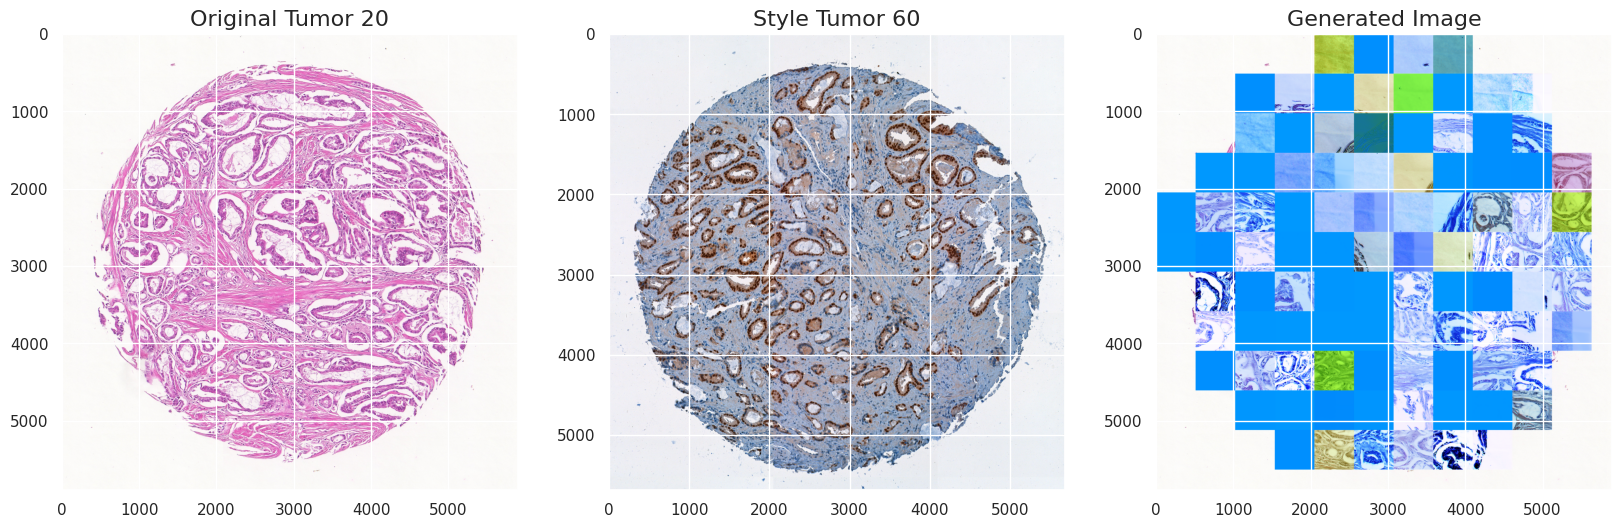

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[torch.randint(0, len(patches_dst), (1,)).item()]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = PatchesUtilities.replace_patches_in_image(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask=PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)

In [41]:
pipeline.eval()
for m in pipeline.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.train()


In [42]:
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches_full(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches_full(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  20
idx_dst:  60


Text(0.5, 1.0, 'Generated Image')

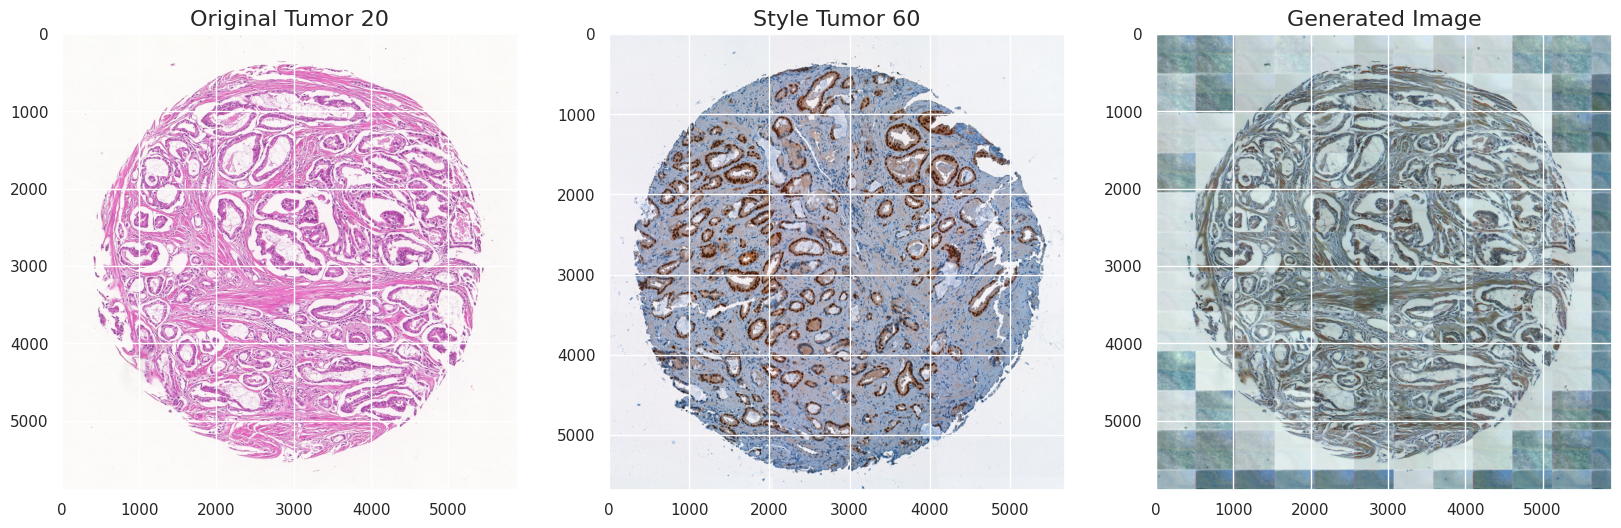

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[torch.randint(0, len(patches_dst), (1,)).item()]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = PatchesUtilities.replace_patches_in_image_full(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)